# UCI Diabetes Data Analysis & Prediction
Sean Ma, 9/27/2019


From Phil - 
>Please use the following small dataset to build a predictive model with **re-admission** as a _target variable_. It would be helpful if you can _catalog your thoughts and workflow on how you pre-process and use the data to build a model of your choice_. Just keep in mind that _the final model's accuracy, AUC, etc. is not as important_ as the steps you took to get to it.

Paper Citation:
>Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore, “Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records,” BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014.

Data Source: https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008#

## Approach plan
1. Profile the data to look at different angles (including the use of `pandas_profiling`)(results included at the end as a _Reference_.
2. Preprocess the data from based off data profiling learning and reading the 2014 paper.
3. Further preprocessing with `vtreat` package 



## Import libraries

In [122]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn

# ranking stuff
from collections import Counter, OrderedDict

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import mean_squared_error, r2_score

# different model estimators
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# model ensemble
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
                              ExtraTreesClassifier, VotingClassifier)

# import cloned icd9 package (https://github.com/sirrice/icd9)
# import sys
# sys.path.append('../icd9')
from icd9.icd9 import ICD9

## Notebook setup

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Import data

In [130]:
dataRaw = pd.read_csv('./diabetic_data.csv')
dataRaw.shape
dataRaw.head(10)

(101766, 50)

encounter_id  patient_nbr             race  gender       age weight  admission_type_id  discharge_disposition_id  admission_source_id  time_in_hospital payer_code         medical_specialty  num_lab_procedures  num_procedures  num_medications  number_outpatient  number_emergency  number_inpatient  diag_1  diag_2 diag_3  number_diagnoses max_glu_serum A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide examide citoglipton insulin glyburide-metformin glipizide-metformin glimepiride-pioglitazone metformin-rosiglitazone metformin-pioglitazone change diabetesMed readmitted
0       2278392      8222157        Caucasian  Female    [0-10)      ?                  6                        25                    1                 1          ?  Pediatrics-Endocrinology                  41               0                1                  0                 0                 0  250.83       ?      ?                 1          None      None        No          No          No             No          No            No        No        No          No           No            No       No       No           No         No      No          No      No                  No                  No                       No                      No                     No     No          No         NO
1        149190     55629189        Caucasian  Female   [10-20)      ?                  1                         1                    7                 3          ?                         ?                  59               0               18                  0                 0                 0     276  250.01    255                 9          None      None        No          No          No             No          No            No        No        No          No           No            No       No       No           No         No      No          No      Up                  No                  No                       No                      No                     No     Ch         Yes        >30
2         64410     86047875  AfricanAmerican  Female   [20-30)      ?                  1                         1                    7                 2          ?                         ?                  11               5               13                  2                 0                 1     648     250    V27                 6          None      None        No          No          No             No          No            No    Steady        No          No           No            No       No       No           No         No      No          No      No                  No                  No                       No                      No                     No     No         Yes         NO
3        500364     82442376        Caucasian    Male   [30-40)      ?                  1                         1                    7                 2          ?                         ?                  44               1               16                  0                 0                 0       8  250.43    403                 7          None      None        No          No          No             No          No            No        No        No          No           No            No       No       No           No         No      No          No      Up                  No                  No                       No                      No                     No     Ch         Yes         NO
4         16680     42519267        Caucasian    Male   [40-50)      ?                  1                         1                    7                 1          ?                         ?                  51               0                8                  0                 0                 0     197     157    250                 5          None      None        No          No          No             No          No            No    Stead

## Glance the data

In [131]:
dataRaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96ae42c400>,
      dtype=object)

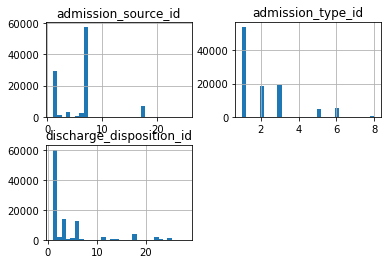

In [132]:
# Take a look at to reduce dimension
dataRaw.hist(column=['admission_type_id', 'discharge_disposition_id','admission_source_id'], bins=30)

In [133]:
# Unique Patients (many have multiple Encounters)
dataRaw.patient_nbr.nunique()

71518

Since the unique patients is 30k less than the actual Encounters *(71518 vs. 101766)*, one strategy is to pull the **last** Encounter (assuming its the most serious one) for model training. Another possible assumption that could be used is the higher value the Ecounter #, the closer the Encounter occured to today.

In [134]:
# Examine discharge type and counts
# sort by type
x = Counter(dataRaw.discharge_disposition_id)
sorted(x.items(), key=lambda pair: pair[0], reverse=False)

# sort by counts
dataRaw['discharge_disposition_id'].value_counts(dropna=False)

[(1, 60234),
 (2, 2128),
 (3, 13954),
 (4, 815),
 (5, 1184),
 (6, 12902),
 (7, 623),
 (8, 108),
 (9, 21),
 (10, 6),
 (11, 1642),
 (12, 3),
 (13, 399),
 (14, 372),
 (15, 63),
 (16, 11),
 (17, 14),
 (18, 3691),
 (19, 8),
 (20, 2),
 (22, 1993),
 (23, 412),
 (24, 48),
 (25, 989),
 (27, 5),
 (28, 139)]

1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

## Preprocessing

Procedures:
1. Re-map `Age` from brackets to median value.
1. Drop `Weights` column due to not captured prior to HITECH act (mentioned in original paper)
2. Remove `Discharge Type` that ends in hospice or died.
3. Define training target `Readmission` for `Yes` if `Readmission` < 30 days, and `No` if else-wise (based off on the CMS penalty for `Readmission` < 30 days in their _HRRP_ program).
4. Filter out multiple **Encounters** per patient?? Need testing. 

In [135]:
# check data shape
dataRaw.shape

# Remap `age`
age_dict = {
    '[0-10)': 5,
    '[10-20)': 15, 
    '[20-30)': 25, 
    '[30-40)': 35, 
    '[40-50)': 45, 
    '[50-60)': 55, 
    '[60-70)': 65, 
    '[70-80)': 75, 
    '[80-90)': 85, 
    '[90-100)': 95 
}

dataRaw['age_median'] = dataRaw['age'].map(age_dict)
dataRaw.drop(['age'], axis=1, inplace=True)

# Drop `weight`
dataRaw.drop(['weight'], axis=1, inplace=True)

# Remove hospice & death
terminal = [11,13,14,19,20,21]
dataRaw = dataRaw[~dataRaw.discharge_disposition_id.isin(terminal)]

# Define training target
readmit = {
    '<30': 'Yes',
    '>30': 'No',
    'NO': 'No'
}
# dataRaw['TargetReadmit'] = dataRaw['readmitted'].map(readmit)
dataRaw['TargetReadmit_Bool'] = dataRaw['readmitted'] == '<30'
dataRaw.drop(['readmitted'], axis=1, inplace=True)

# Filter out 1 Encounter per 1 patient
dataRaw.drop(['encounter_id'], axis=1, inplace=True)
dataRaw.drop(['patient_nbr'], axis=1, inplace=True)

# check data
dataRaw.sample(20)
dataRaw.shape

(101766, 50)

race  gender  admission_type_id  discharge_disposition_id  admission_source_id  time_in_hospital payer_code       medical_specialty  num_lab_procedures  num_procedures  num_medications  number_outpatient  number_emergency  number_inpatient  diag_1  diag_2  diag_3  number_diagnoses max_glu_serum A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide examide citoglipton insulin glyburide-metformin glipizide-metformin glimepiride-pioglitazone metformin-rosiglitazone metformin-pioglitazone change diabetesMed  age_median  TargetReadmit_Bool
60068        Caucasian  Female                  1                         3                    7                 3         MC                       ?                  34               0               19                  0                 0                 1     410     428     496                 8          None      None        No          No          No             No          No            No    Steady        No          No           No            No       No       No           No         No      No          No    Down                  No                  No                       No                      No                     No     Ch         Yes          85               False
21141        Caucasian  Female                  1                         1                    7                 3          ?        InternalMedicine                  35               0               23                  0                 0                 0     493  250.02     278                 5          None      None    Steady          No          No             No          No            No    Steady        No          No           No        Steady       No       No           No         No      No          No  Steady                  No                  No                       No                      No                     No     Ch         Yes          55               False
38155        Caucasian    Male                  1                         1                    7                 5          ?        InternalMedicine                  78               2               17                  0                 0                 0     577     276     574                 9          None      Norm        No          No          No             No          No            No        No        No          No           No            No       No       No           No         No      No          No  Steady                  No                  No                       No                      No                     No     No         Yes          65               False
50525            Other  Female                  1                         1                    7                 1          ?                       ?                  32               0                9                  0                 0                 0     998     682  250.02                 9          None      None        No          No          No             No          No            No        No        No          No           No            No       No       No           No         No      No          No      No                  No                  No                       No                      No                     No     No          No          55               False
35825                ?    Male                  1                         1                    6                 9         HM        InternalMedicine                  79               1               17                  0                 0                 0      38     428     427                 5          None      None        No          No          No             No          No            No        No        No          No           No            No       No       No           No         No      No          No  Steady                  No                

(99343, 47)

## Split Train / Test sets
We will use a 70% / 30% split for training and test sets. This includes shuffling amongst all rows.

In [162]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataRaw, test_size=0.3, random_state=42)

## Preprocess /w `vtreat`
`vtreat` is a package that handles the preprocessing for missing data, categorical variables (too many levels), scaling, etc., where it generates a completely numeric dataframe (with no missing value) that is ready for model training. It was originally developed in `R`, which I was used under previously, but recently got ported to the `python` environment.

More information, including tutorials, can be found here: https://github.com/WinVector/pyvtreat

In [136]:
import vtreat
import vtreat.util
import wvpy.util

First, let's verify the train/test data set carries close prevalence for Readmission < 30 of the whole population.

In [163]:
# Calculate prevalence ration for Readmission < 30
np.mean(dataRaw['TargetReadmit_Bool'])
np.mean(train['TargetReadmit_Bool'])
np.mean(test['TargetReadmit_Bool'])

0.11388824577474005

0.11321541558815071

0.11545817535147468

Next, let's setup a `vtreat` transformation object based off of the target column and the positive value for Readmission < 30: True. 

In [164]:
# Setup treatment transform object for classification
transform = vtreat.BinomialOutcomeTreatment(
    outcome_name='TargetReadmit_Bool',    # outcome variable (has to be Boolean)
    outcome_target=True  # outcome of interest
)  

Transform the **train** dataset. The same transformer will be used for the **test** dataset later for prediction.

In [165]:
# transform the train dataset: completely numeric, with no missing value
trainPrep = transform.fit_transform(train, train['TargetReadmit_Bool'])

### What is `vtreat` doing?

To understand what `vtreat::transform` has done on the original dataframe, let's take a look on its new data structure, which includes some newly introduced variables with treatments such as: `indicator_code`, `logit_code`, `prevalence_code`, etc.

`indicator_code`: similar to the new columns generated after `one-hot` encoding. These columns map out a single categorical variable to a new column with (0, 1) values indicating inclusion or not.

`logit_code`:  from categorical variables: score from a one-dimensional model of the centered output as a function of the variable.

`prevalence_code`: from categorical variables. Indicates how often each level of the variable was "on".

In [166]:
# score frame /w info re: transformed new variables
transform.score_frame_

variable             orig_variable        treatment  y_aware  has_range  PearsonR  significance  vcount  default_threshold  recommended
0                           admission_type_id         admission_type_id       clean_copy    False       True -0.013644  3.204833e-04    12.0           0.020833         True
1                    discharge_disposition_id  discharge_disposition_id       clean_copy    False       True  0.063598  3.004865e-63    12.0           0.020833         True
2                         admission_source_id       admission_source_id       clean_copy    False       True  0.004039  2.868697e-01    12.0           0.020833        False
3                            time_in_hospital          time_in_hospital       clean_copy    False       True  0.047724  2.340164e-36    12.0           0.020833         True
4                          num_lab_procedures        num_lab_procedures       clean_copy    False       True  0.025619  1.409314e-11    12.0           0.020833         True
5                              num_procedures            num_procedures       clean_copy    False       True -0.012865  6.921451e-04    12.0           0.020833         True
6                             num_medications           num_medications       clean_copy    False       True  0.039398  2.658745e-25    12.0           0.020833         True
7                           number_outpatient         number_outpatient       clean_copy    False       True  0.021412  1.633098e-08    12.0           0.020833         True
8                            number_emergency          number_emergency       clean_copy    False       True  0.059722  5.609296e-56    12.0           0.020833         True
9                            number_inpatient          number_inpatient       clean_copy    False       True  0.167454  0.000000e+00    12.0           0.020833         True
10                           number_diagnoses          number_diagnoses       clean_copy    False       True  0.052759  4.633872e-44    12.0           0.020833         True
11                                 age_median                age_median       clean_copy    False       True  0.024166  1.846573e-10    12.0           0.020833         True
12                            race_logit_code                      race       logit_code     True       True  0.015160  6.390692e-05    31.0           0.008065         True
13                       race_prevalence_code                      race  prevalence_code    False       True  0.007206  5.740036e-02    34.0           0.007353        False
14                         race_lev_Caucasian                      race   indicator_code    False       True  0.005277  1.640937e-01    43.0           0.005814        False
15                   race_lev_AfricanAmerican                      race   indicator_code    False       True  0.003653  3.353548e-01    43.0           0.005814        False
16                          gender_logit_code                    gender       logit_code     True       True  0.004359  2.503966e-01    31.0           0.008065        False
17                     gender_prevalence_code                    gender  prevalence_code    False       True  0.005112  1.776175e-01    34.0           0.007353        False
18                          gender_lev_Female                    gender   indicator_code    False       True  0.004948  1.919610e-01    43.0           0.005814        False
19                            gender_lev_Male                    gender   indicator_code    False       True -0.004917  1.947502e-01    43.0           0.005814        False
20                      payer_code_logit_code                payer_code       logit_code     True       True  0.028984  2.094680e-14    31.0           0.008065         True
21                 payer_code_prevalence_code                payer_code  prevalence_code    False       True  0.025685  1.250503e-11    34.0           0.007353         True
22                           payer_code_lev_?             

### Non-recommended variables after `vtreat`

Many of these non-recommended variables are straightforward, such as the missing values for the `payer_code` and many of the 24 medicine codes with a level of *No*. 

In [167]:
# Not recommended variables
transform.score_frame_.loc[~transform.score_frame_['recommended'], ['variable']]

variable
2                         admission_source_id
13                       race_prevalence_code
14                         race_lev_Caucasian
15                   race_lev_AfricanAmerican
16                          gender_logit_code
17                     gender_prevalence_code
18                          gender_lev_Female
19                            gender_lev_Male
22                           payer_code_lev_?
27     medical_specialty_lev_InternalMedicine
29                     diag_1_prevalence_code
31                     diag_2_prevalence_code
36              max_glu_serum_prevalence_code
37                     max_glu_serum_lev_None
45                     repaglinide_logit_code
46                repaglinide_prevalence_code
47                         repaglinide_lev_No
48                     nateglinide_logit_code
49                nateglinide_prevalence_code
50                         nateglinide_lev_No
51                  chlorpropamide_logit_code
52             chlorpropamide_prevalence_code
53                      chlorpropamide_lev_No
56                         glimepiride_lev_No
57                   acetohexamide_logit_code
58              acetohexamide_prevalence_code
59                       acetohexamide_lev_No
60                       glipizide_logit_code
61                  glipizide_prevalence_code
62                           glipizide_lev_No
63                       glipizide_lev_Steady
64                       glyburide_logit_code
65                  glyburide_prevalence_code
66                           glyburide_lev_No
67                     tolbutamide_logit_code
68                tolbutamide_prevalence_code
69                         tolbutamide_lev_No
70                    pioglitazone_logit_code
71               pioglitazone_prevalence_code
72                        pioglitazone_lev_No
73                   rosiglitazone_logit_code
75                       rosiglitazone_lev_No
76                        acarbose_logit_code
77                   acarbose_prevalence_code
78                            acarbose_lev_No
79                        miglitol_logit_code
80                   miglitol_prevalence_code
81                            miglitol_lev_No
82                    troglitazone_logit_code
83               troglitazone_prevalence_code
84                        troglitazone_lev_No
85                      tolazamide_logit_code
86                 tolazamide_prevalence_code
87                          tolazamide_lev_No
88                    examide_prevalence_code
89                             examide_lev_No
90                citoglipton_prevalence_code
91                         citoglipton_lev_No
95                         insulin_lev_Steady
98             glyburide-metformin_logit_code
99        glyburide-metformin_prevalence_code
100                glyburide-metformin_lev_No
101            glipizide-metformin_logit_code
102       glipizide-metformin_prevalence_code
103                glipizide-metformin_lev_No
104       glimepiride-pioglitazone_logit_code
105  glimepiride-pioglitazone_prevalence_code
106           glimepiride-pioglitazone_lev_No
107        metformin-rosiglitazone_logit_code
108   metformin-rosiglitazone_prevalence_code
109            metformin-rosiglitazone_lev_No
110    metformin-pioglitazone_prevalence_code
111             metformin-pioglitazone_lev_No

### Ready to model `vtreat` dataframe

`vtreat` automatically excludes variables that were **not recommended** out of the treated dataframe for modeling. Those, however, can be included back manually if needed.

In [168]:
trainPrep.head()
trainPrep.shape

TargetReadmit_Bool  admission_type_id  discharge_disposition_id  time_in_hospital  num_lab_procedures  num_procedures  num_medications  number_outpatient  number_emergency  number_inpatient  number_diagnoses  age_median  race_logit_code  payer_code_logit_code  payer_code_prevalence_code  payer_code_lev_MC  medical_specialty_logit_code  medical_specialty_prevalence_code  medical_specialty_lev_?  diag_1_logit_code  diag_2_logit_code  diag_3_logit_code  diag_3_prevalence_code  diag_3_lev_250  max_glu_serum_logit_code  A1Cresult_logit_code  A1Cresult_prevalence_code  A1Cresult_lev_None  metformin_logit_code  metformin_prevalence_code  metformin_lev_No  metformin_lev_Steady  glimepiride_logit_code  glimepiride_prevalence_code  rosiglitazone_prevalence_code  insulin_logit_code  insulin_prevalence_code  insulin_lev_No  insulin_lev_Down  insulin_lev_Up  change_logit_code  change_prevalence_code  change_lev_No  change_lev_Ch  diabetesMed_logit_code  diabetesMed_prevalence_code  \
0               False                3.0                       6.0              11.0                59.0             4.0             45.0                0.0               0.0               0.0               9.0        65.0         0.009689               0.062721                    0.315646                1.0                      0.038495                           0.491933                      1.0          -0.158526          -0.257113           0.155358                0.025223             0.0                 -0.004425              0.022035                   0.829652                 1.0              0.034095                   0.800000               1.0                   0.0               -0.194627                     0.046362                       0.937460            0.140878                 0.110368             0.0               0.0             1.0           0.051695                0.464409            0.0            1.0                0.035294                     0.771225   
1               False                2.0                       1.0               4.0                75.0             1.0              9.0                0.0               0.0               0.0               5.0        45.0         0.010039              -0.225488                    0.024116                0.0                      0.055372                           0.142882                      0.0           0.112705           0.065696           0.159886                0.001999             0.0                 -0.005218              0.027097                   0.829652                 1.0              0.036236                   0.800000               1.0                   0.0                0.004927                     0.948763                       0.937460           -0.022007                 0.301237             0.0               0.0             0.0          -0.044392                0.535591            1.0            0.0                0.037418                     0.771225   
2               False                1.0                       3.0               4.0                 1.0             1.0              3.0                0.0               0.0               1.0               9.0        75.0         0.010039              -0.114833                    0.049267                0.0                     -0.057951                           0.073540                      0.0           0.326137           0.381122          -0.166090                0.013690             0.0                 -0.005218              0.027097                   0.829652                 1.0              0.036236                   0.800000               1.0                   0.0                0.004927                     0.948763                       0.937460            0.222390                 0.120909             0.0               1.0             0.0           0.048614                0.464409            0.0            1.0                0.037418                     0.771225   
3               False                1.0       

(69540, 48)

### Separate Data / Target columns for training

In [170]:
targetCol = 'TargetReadmit_Bool'
inputCol = [v for v in trainPrep.columns if v != targetCol]

target = trainPrep[[targetCol]]
data = trainPrep[inputCol]

target.shape
data.shape

(69540, 1)

(69540, 47)

## Prediction Models

In [175]:
## Multiple model classification with proper `kfolds`

# random state
RANDOM_STATE = 42
np.random.seed(42)

# model parameters
dt_params = {'max_features': 18,
             'splitter': 'best',
             'criterion': 'gini',
             'max_depth': 4,
             'min_samples_leaf': 8}

xt_params = {'min_samples_leaf': 1,
             'min_samples_split': 5,
             'n_estimators': 150}

gbt_params = {'min_samples_split': 2,
              'loss': 'exponential',
              'learning_rate': 0.5,
              'n_estimators': 100,
              'max_depth': 2}

knn_params = {'n_neighbors': 10,
              'algorithm': 'auto',
              'weights': 'distance',
              'leaf_size': 45}

logreg_params = {'C': 100,
                 'tol': 0.00001,
                 'class_weight': 'balanced',
                 'solver': 'lbfgs'}

reg_params = {'C': 100,
                 'tol': 0.00001,
                 #'class_weight': 'balanced',
                 'solver': 'liblinear'}

rf_params = {'min_samples_split': 2,
             'n_estimators': 100,
             'criterion': 'gini',
             'max_depth': None,
             'min_samples_leaf': 2}

svm_params = {'C': 22, 'gamma': 0.1}

xgb_params = {'learning_rate': 0.2,
              'n_estimators': 1000,
              'objective': 'binary:logistic',
              'max_depth': 5,
              'min_child_weight': 1,
              'subsample': 0.8, 
              'gamma': 0,
              'random_state': RANDOM_STATE}

ada_params = {'n_estimators': 200,
              'learning_rate': 0.1}

# model alias & setup
dt_model = DecisionTreeClassifier(**dt_params)
xt_model = ExtraTreesClassifier(**xt_params)
gbt_model = GradientBoostingClassifier(**gbt_params)
knn_model = KNeighborsClassifier(**knn_params)
logreg_model = LogisticRegression(C=10000)
reg_model = LinearRegression()
rf_model = RandomForestClassifier(**rf_params)
svm_model = SVC(**svm_params)
xgb_model = XGBClassifier(**xgb_params)
gNB_model = GaussianNB()
ada_model = AdaBoostClassifier(**ada_params)

# models and labels for training
models = {
    dt_model : 'DecisionTree',
    xt_model : 'ExtraTree',
    gbt_model : 'GradientBoosting',
    knn_model : 'KNN',
    #reg_model : 'LinearRegression'
    logreg_model : 'LogisticRegression',
    rf_model : 'RandomForest',
    #svm_model : 'SVM',
    xgb_model : 'XGBoost',
    gNB_model : 'GaussianNB',
    #ada_model : 'AdaBoost'
}

In [ ]:
# data split & grid search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

# oversampling
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN

# Pipeline initiation
from imblearn.pipeline import make_pipeline, Pipeline

# hyper-parameter tuning
# from bayes_opt import BayesianOptimization

# Pickle 
import pickle

# random state
RANDOM_STATE = 42

# score type
score = 'roc_auc'  #'accuracy','f1'

# initialization
acc_mean =[]
acc_std =[]
acc = []

# cross validation strategy:: StratifiedKFold
# https://scikit-learn.org/stable/modules/cross_validation.html
cv_folds = StratifiedKFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)

# over=sampling initialization
smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
ada = ADASYN(sampling_strategy='minority', random_state=RANDOM_STATE)

# Training different models
# TODO:: use cross validation Kfolds to compare results
# looping over models ==> need to parallelize
for i_mod, i_mod_name in models.items(): #zip(model, model_name):
    
    # initialization
    pipe = []
    clf_fit = []
    cnf_mat = []
    test_preds_prob = []
    test_preds = []
    
    # Pipeline definition
    pipe = Pipeline([
        ('smote', smote),
        #('ada', ada),
        ('clf', i_mod)
    ])

    # estimating model score
    print(" --- starting {0} ---\n".format(i_mod_name))
    
    cv_score = cross_val_score(estimator = pipe,
                                X = data.values,
                                y = target.values, 
                                cv = cv_folds,
                                scoring = score,
                                n_jobs = 4)
        
    print("  cv-{0} {1}\n".format(score, cv_score))
    
    # dump the model into pickle
    # cross_val_score() does not fit the model but makes a copy of the model for cv
    # https://stackoverflow.com/questions/36215700
    # print("Saving fitted model")
    # pickle.dump(i_mod, open(i_mod_name+'.pkl', 'wb')) 
    
    # stacking accuracy
    acc_mean.append(cv_score.mean())
    acc_std.append(cv_score.std())
    acc.append(cv_score)
    
    # prediction section
    print("  Fitting model & Saving model")
    clf_fit = pipe.fit(data.values, target.values)
    
    # saving the fitted model
    pickle.dump(clf_fit, open('Trained_' +i_mod_name +'_' +targetCol +'.pkl', 'wb')) 
   
# construct ALL accuracy dataframe
acc_mean_df = pd.DataFrame({score+'_Mean': acc_mean, score+'_Std': acc_std}, index = models.values())       
display(acc_mean_df)

# plotting accuracy scores
rcParams['figure.figsize'] = (10, 6)
acc_df = pd.DataFrame(acc, index = models.values())
acc_df.T.plot(kind = 'box')
plt.title(score+" Score")

 --- starting DecisionTree ---

  cv-roc_auc [0.61663264 0.61561342 0.56552983 0.59201865 0.55854448 0.62791781
 0.62853881 0.57154484 0.60735956 0.59686229]

  Fitting model & Saving model


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 --- starting ExtraTree ---



## Prepare `test` dataset for prediction

In [171]:
# prepare the new data with vtreat
testPrep = transform.transform(test)  # differs than the .fit_transform() for train data

# remove the target label
test_target = testPrep[[targetCol]]
test_data = testPrep[inputCol]

test_target.shape
test_data.shape

(29803, 1)

(29803, 47)

## Define calibration metrics

In [172]:
# define visualization for confusion matrix
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # restructure confusion matrix to conventional [tp fn; fp tn]
    tn, fp, fn, tp = cm.ravel()
    cm = np.array([np.array([tp, fp]), np.array([fn, tn])])
    cm_label = np.array([np.array(['TP', 'FP']), np.array(['FN', 'TN'])])

    # plot confusion matrix grid
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print("Confusion Matrix array")
    print(cm)

    # labeling confusion matrix /w numbers
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # concat confusion matrix labels with values
        string = cm_label[i, j] + ":\n" + str(cm[i, j])
        plt.text(j,
                 i,
                 string,
                 fontsize=16,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel('Actual')
    plt.ylabel('Predicted ', rotation=0)

# ### Calculate benchmark metrics
# Definition
def pr_metrics(conf_matrix, data_name, print_true):
    # tn = conf_matrix[0, 0]  # True negative; Correct rejection
    # fp = conf_matrix[0, 1]  # False positive; False alarm; Type I Error
    # fn = conf_matrix[1, 0]  # False negative; Miss; Type II Error
    # tp = conf_matrix[1, 1]  # True positive; Hit
    tn, fp, fn, tp = conf_matrix.ravel()

    # Precision & Recall Definition
    tpr = tp / (tp + fn)  # Sensitivity; Recall; True positive rate
    tnr = tn / (tn + fp)  # Sepcificity; Selectivity; True negative rate
    ppv = tp / (tp + fp)  # Positive predictive value; Precision
    npv = tn / (fn + tn)  # Negative predictive value
    fm = 2 * tpr * tnr / (tpr + tnr)  # F measure
    Acc = (tp + tn) / (tp + tn + fp + fn)

    # print out
    if print_true == 1:
        print(
            "{0:s} data - True Positive Rate (Sensitivity or Recall)      : {1:1.4f}"
            .format(data_name, tpr))
        print(
            "{0:s} data - True Negative Rate (Specificity or Selectivity) : {1:1.4f}"
            .format(data_name, tnr))
        print(
            "{0:s} data - Positive Predictive Value (Precision)           : {1:1.4f}"
            .format(data_name, ppv))
        print(
            "{0:s} data - Negative Predictive Value                       : {1:1.4f}"
            .format(data_name, npv))
        print(
            "{0:s} data - Accuracy=(True Pos + True Neg)/Total Population : {1:1.4f}"
            .format(data_name, Acc))
        print(
            "{0:s} data - F-score (Dice similarity coefficient)           : {1:1.4f}"
            .format(data_name, fm))
        print("")

    return tpr, tnr, ppv, npv, fm, Acc

## Select & Benchmark Model
Select `GradientBoosting` trained model and see how classification metrics differs for **train vs. test** dataset for overfitting or underfitting concerns.

In [174]:
# load pickle model
fitmodel = pickle.load(open('Trained_GradientBoosting_TargetReadmit_Bool.pkl', 'rb'))

# apply the model to the prepared data
# dtest_prepared['prediction'] = fitmodel.predict_proba(test_data.values)[:, 1]

test_pred = fitmodel.predict(test_data.values)
test_predProb = fitmodel.predict_proba(test_data.values)

# Test dataset confusion matrix
cnf_mat = confusion_matrix(test_target, test_pred)

# Plot non-normalized confusion matrix
class_names = [True, False]  #['High', 'Low']
plt.figure()
plot_confusion_matrix(cnf_mat,
                      classes=class_names,
                      title='Confusion matrix - Test (unseen) dataset')
plt.show()

# Precision/Recall printout
pr_metrics(cnf_mat, 'Test', 1)

ValueError: Number of features of the model must match the input. Model n_features is 49 and input n_features is 47 

----------------------------

## Reference[1]: Data Profiling

In [8]:
# Data Profiling
import pandas_profiling as pp
import warnings

# limit warnings for once
warnings.filterwarnings(action='once')

# actual profiling (missing correlation)
pp.ProfileReport(dataRaw)

## Reference[2]: ICD 9 Coding

1. Package Source: https://github.com/sirrice/icd9
2. Reference: ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Publications/ICD-9/ucod.txt

In [21]:
# Test ICD9 /w diag_1/diag_2/diag_3
icdtree = ICD9('../icd9/codes.json')

toplevelnodes = icdtree.children
toplevelcodes = [node.code for node in toplevelnodes]
print(toplevelcodes)

icdtree.find('428').descr
icdtree.find('414').descr
icdtree.find('786').descr

['001-139', '140-239', '240-279', '280-289', '290-319', '320-389', '390-459', '460-519', '520-579', '580-629', '630-679', '680-709', '710-739', '740-759', '760-779', '780-799', '800-999', 'V01-V06', 'V07-V09', 'V10-V19', 'V20-V29', 'V30-V39', 'V40-V49', 'V50-V59', 'V60-V69', 'V70-V82', 'V83-V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'E979', 'E849', 'E800-E807', 'E810-E819', 'E820-E825', 'E826-E829', 'E830-E838', 'E840-E845', 'E846-E848', 'E850-E858', 'E860-E869', 'E870-E876', 'E878-E879', 'E880-E888', 'E890-E899', 'E900-E909', 'E910-E915', 'E916-E928', 'E929', 'E930-E949', 'E950-E959', 'E960-E969', 'E970-E978', 'E980-E989', 'E990-E999']


'Heart failure'

'Other forms of chronic ischemic heart disease'

'Symptoms involving respiratory system and other chest symptoms'